### Customer Profiling Based on Transaction Data in December 2017

### Import Library and Database Connection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('ggplot')
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import os
import cx_Oracle


dsn_tns = cx_Oracle.makedsn("10.10.15.38", '1528', 'ORCL')
db = cx_Oracle.connect('AML_DEMO', 'AML_DEMO', dsn_tns)

### Top 10 City with The Highest Number of Transaction 

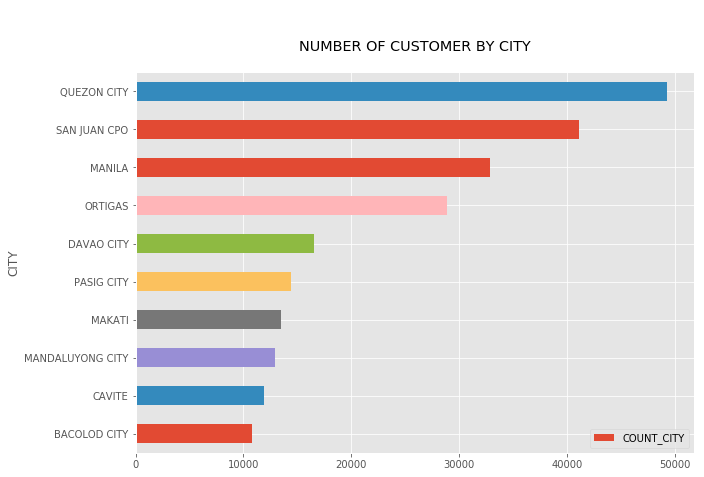

In [24]:
qcity = """
SELECT a.city, COUNT(a.city) AS count_city FROM AML_CUSTOMER a, AML_TRANSACTION b 
WHERE a.cif_key = b.CIF_KEY
AND b.tran_dt BETWEEN TO_DATE('01-12-2017','dd-mm-yyyy') AND TO_DATE('30-12-2017','dd-mm-yyyy')
GROUP BY city ORDER BY count_city DESC"""

dfcity = pd.read_sql(qcity,con=db)
dfcity = dfcity.head(11)

dfcity = dfcity.drop(dfcity.index[4])   #remove 4 - NONE
dfcity = dfcity.sort_values('COUNT_CITY', ascending=True)   #data read in ascending but plotted descending

ax = dfcity.plot.barh(x='CITY', y='COUNT_CITY', rot=0, figsize=(10,7), title='\n\nNUMBER OF CUSTOMER BY CITY\n')

### Business Source List Based on Transaction 

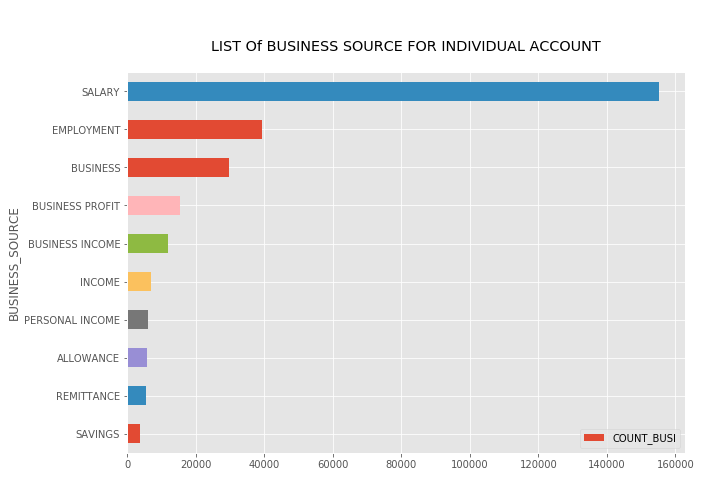

In [23]:
source = """
SELECT * FROM (SELECT a.business_source, COUNT(a.business_source) 
AS count_busi 
FROM AML_CUSTOMER a, AML_TRANSACTION b
WHERE a.cif_key = b.cif_key 
AND a.customer_cat = 'I'
AND b.tran_dt BETWEEN TO_DATE('01-12-2017','dd-mm-yyyy') AND TO_DATE('30-12-2017','dd-mm-yyyy')
GROUP BY a.business_source ORDER BY count_busi DESC)
WHERE count_busi != 0"""

df_source= pd.read_sql(source,con=db)
df_source = df_source.head(10)
df_source = df_source.sort_values('COUNT_BUSI', ascending=True)

#fig = plt.figure()
#ax1 = fig.add_subplot(131)
#ax2 = fig.add_subplot(133)

ax = df_source.head(10).plot.barh(x='BUSINESS_SOURCE', y='COUNT_BUSI', rot=0, figsize=(10,7), title='\n\nLIST Of BUSINESS SOURCE FOR INDIVIDUAL ACCOUNT\n')



### Select statement query from database

Let say,  
<ol>
  <li>City - Manila</li>
  <li>Source - Salary</li>
  <li>Module - Saving Account</li>
  <li>Start Date - 1st January 2017</li>
  <li>From Date - 30th December 2017</li>
</ol>

In [4]:
query = """
SELECT * FROM 
(SELECT a.cif_key, COUNT(a.base_equivalent) AS COUNT, 
ROUND(AVG(a.base_equivalent)) AS AVERAGE, 
ROUND(MAX(a.base_equivalent)) AS MAX,
ROUND(MIN(a.base_equivalent)) AS MIN,b.AGE 
FROM AML_TRANSACTION a, AML_CUSTOMER b
WHERE a.CIF_KEY = b.CIF_KEY
AND a.tran_dt BETWEEN TO_DATE('01-01-2017','dd-mm-yyyy') AND TO_DATE('30-12-2017','dd-mm-yyyy')
AND b.city = 'MANILA'
AND b.customer_cat = 'I'
AND a.module = 'SA'
AND b.business_source = 'SALARY'
GROUP BY a.cif_key, b.AGE) WHERE COUNT >= 50 AND AVERAGE != 0 AND MAX != 0 ORDER BY COUNT DESC"""

df = pd.read_sql(query,con=db)
df['AVERAGE'] = df['AVERAGE'].abs()
df['MAX'] = df['MAX'].abs()

display (df.head(15))  # Display on first 15 rows

,CIF_KEY,COUNT,AVERAGE,MAX,MIN,AGE
0,44470,730,12,30800,-15000,31
1,231399,568,66,167800,-50000,28
2,14680,519,825,710000,-710000,37
3,115296,471,33,66765,-20000,34
4,251991,406,70,3890893,-3000050,38
5,261594,374,4554,154945,-375690,30
6,132261,355,21,9640,-9600,50
7,184027,311,351,52500,-155000,42
8,264464,265,728,100000,-20000,24
9,9386,250,268,80639384,-107373000,71


### Run Elbow Method

<p> This elbow method is to find the most suitable cluster number to use as the parameter in the model </p>

In [34]:
from scipy.spatial.distance import cdist
distortions = []

features = list(df)
dt = df[['COUNT','AVERAGE']].values    # Lets say count and average as the selected features

df[['COUNT','AVERAGE']].head(10)

,COUNT,AVERAGE
0,730,12
1,568,66
2,519,825
3,471,33
4,406,70
5,374,4554
6,355,21
7,311,351
8,265,728
9,250,268


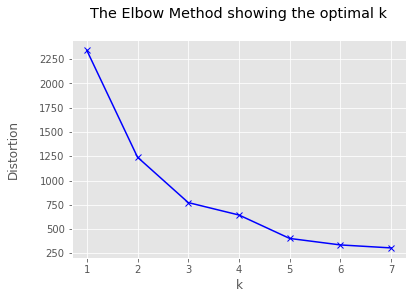

In [25]:
K = range(1,8)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dt)
    kmeanModel.fit(dt)
    distortions.append(sum(np.min(cdist(dt, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dt.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion\n')
plt.title('The Elbow Method showing the optimal k\n')
plt.show()

### Run K-Means Clustering From Selected Features and Visualization

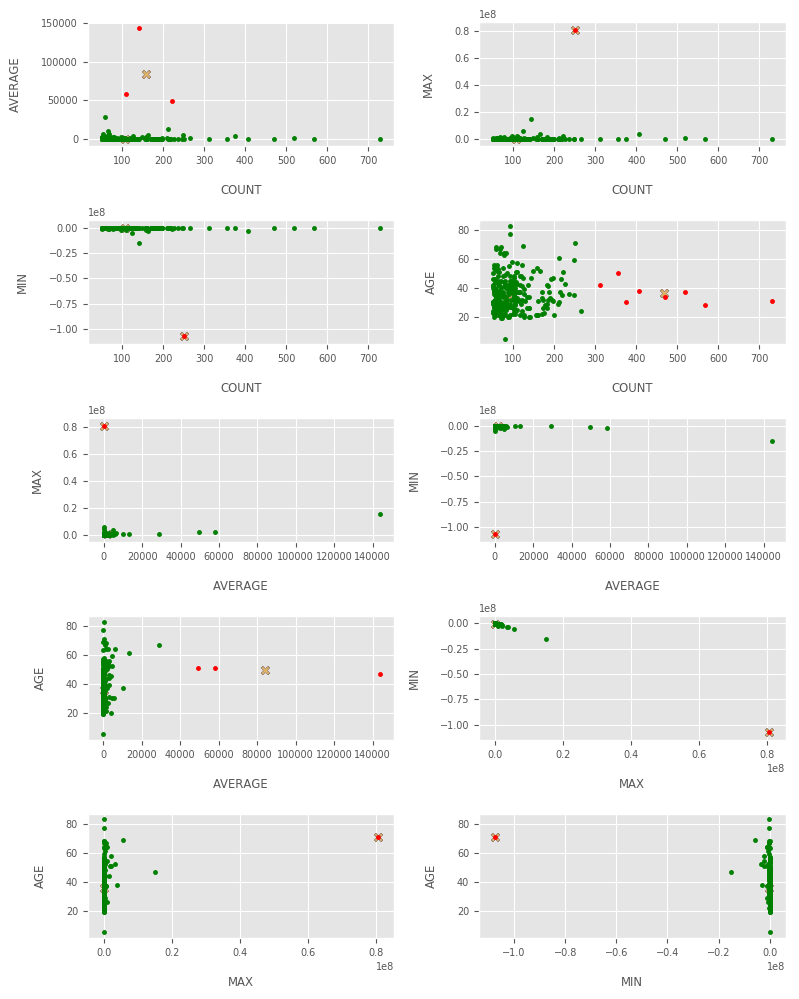

In [20]:
from math import sqrt
from math import ceil

features = list(df)
maxF = len(features) - 1   # exclude cif_key
c_size = int(((maxF-1)*maxF)/2)   # to define the total clusters can be generated
a = 1
c = 2
n = 2
x = c_size/2
x = ceil(x)
q = 1

fig = plt.figure(figsize=(8,10), dpi=100, facecolor='w', edgecolor='k')

plt.rcParams.update({'font.size': 7})     
    
while a < int(maxF):
    b = c

    while b <= int(maxF):   
        dt = []
        dt = df[[features[int(a)],features[int(b)]]].values
        kmeans = KMeans(n_clusters=int(n))
        kmeans.fit(dt)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        colors = ['g.','r.','y.']

        ax = fig.add_subplot(5, 2, q)
        
        for i in range(0, len(dt)):
            ax.plot(dt[i][0], dt[i][1], colors[labels[i]], markersize = 5)
            ax.scatter(centroids[:,0], centroids[:,1], marker = 'x', s=20, linewidths = 10, alpha = 0.8)
            ax.set_xlabel('\n' +features[int(a)]) 
            ax.set_ylabel(features[int(b)]+ '\n')
        q+=1
        b+=1
    a+=1
    c+=1

    
plt.tight_layout()
plt.show()

plt.rcParams.update({'font.size': 10})   

### Define the farthest point from from both centroids

Lets say the last data features that selected as defined to <i><b>dt</b></i> variable is <b>AGE</b> and <b>MIN</b>

In [37]:
from math import sqrt
from array import *

a = 0
maxPointByClusDist = -999
listdist = []
quartemp = []
quarter = []
temp = []
n = 2
dist = []

while a < n:
    for i in range (len(labels)):
        if labels[i] ==  a:
            dist = sqrt( (centroids[a][0] - dt[i][0])**2 + (centroids[a][1] - dt[i][1])**2 )
            temp.append(dist)
            #print (temp)
            
            if dist > maxPointByClusDist:
                maxPointByClusDist = dist
                #print ('Max point : ' +str(maxPointByClusDist))
                maxPointByClusCoor = dt[i][0],dt[i][1]
                #print ('Max coordinate : ' +str(maxPointByClusCoor))
                
    quartemp.append((0.25*(int(centroids[a][0]))) + (0.75*(int(maxPointByClusCoor[0]))))  
    quartemp.append((0.25*(int(centroids[a][1]))) + (0.75*(int(maxPointByClusCoor[1]))))  
    
    print ('Cluster ' +str(a)+' :')
          
    listdist.append(temp)
    quarter.append(quartemp)
    temp = []
    quartemp = []
    a = a+1
    
    print ('Max point : ' +str(maxPointByClusDist))
    print ('Max coordinate : ' +str(maxPointByClusCoor)+ '\n')


Cluster 0 :
Max point : 228952.39721565307
Max coordinate : (142, 144095)

Cluster 1 :
Max point : 107373250.00018072
Max coordinate : (250, 268)

